# End-to-end Solar Out-of-Distribution (SOoD) pipeline

This notebook presents an end-to-end training and prediction pipeline for Anomaly Detection with a context-encoding variational autoencoder.

## Data Acquisition

Make sure to install `sdo-cli` first.

In [3]:
# download the dataset

!sdo-cli data download --path='./data/aia_171_2012' \
    --start='2012-01-01T00:00:00' \
    --end='2012-01-31T23:59:00' \
    --freq='12h' \
    --wavelength='171'

Starting to download images...
loading data for 62 images between 2012-01-01 00:00:00 and 2012-01-31 23:59:00


In [4]:
# resize the images to 256x256

!sdo-cli data resize --path='./data/aia_171_2012' \
    --targetpath='./data/aia_171_2012_256/train' \
    --size="256" \
    --wavelength='171'

Starting to generate resized images...
converting 62 images


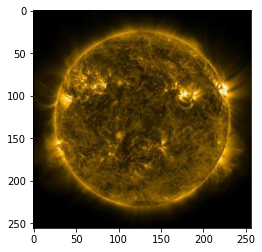

In [5]:
#inspect an image

from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

data_dir = "./data/aia_171_2012_256/train"
aia_wave = 171
images = list(Path(data_dir).rglob(f'*__{aia_wave}.jpeg'))
img_path = images[0]

src_img = Image.open(img_path)
plt.imshow(np.asarray(src_img))

## Training

For a visual inspection of the training process start a [Visdom Server](https://github.com/fossasia/visdom): `make visdom`

In [13]:
# training a ceVAE model for the downloaded images

import os 

output_dir = "./output/train"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

!python3 ../src/sood/algorithms/ce_vae.py --run="train" \
    --target-size=256 \
    --data-dir="./data/aia_171_2012_256" \
    -o "./output/train"\
    --logger visdom \
    --ce-factor 0.5 \
    --score-mode combi \
    --n-epochs 1

Setting up a new session...
VAE(
  (enc): BasicEncoder(
    (start): ConvModule(
      (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (activation): LeakyReLU(negative_slope=0.01)
    )
    (middle_blocks): ModuleList(
      (0): NoOp()
      (1): ConvModule(
        (conv): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (activation): LeakyReLU(negative_slope=0.01)
      )
      (2): NoOp()
      (3): ConvModule(
        (conv): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (activation): LeakyReLU(negative_slope=0.01)
      )
      (4): NoOp()
      (5): ConvModule(
        (conv): Conv2d(256, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (activation): LeakyReLU(negative_slope=0.01)
      )
    )
    (end): ConvModule(
      (conv): Conv2d(1024, 256, kernel_size=[16, 16], stride=(1, 1), bias=False)
    )
  )
  (dec): BasicGenerator(
 

## Predict

In [19]:
# download a test sequence

!sdo-cli data download \
    --path='./data/aia_171_2012_full_disk_flare' \
    --start='2012-03-07T00:02:00' \
    --end='2012-03-07T00:40:00' \
    --freq='6min' \
    --wavelength='171'

!sdo-cli data resize \
    --path='./data/aia_171_2012_full_disk_flare' \
    --targetpath='./data/aia_171_2012_full_disk_flare_256/test' \
    --wavelength='171' \
    --size=256

Starting to download images...
loading data for 7 images between 2012-03-07 00:02:00 and 2012-03-07 00:40:00
Starting to generate resized images...
converting 7 images


In [9]:
# pixel-level predictions

import os 

pred_output_dir = "./output/pred"
if not os.path.exists(pred_output_dir):
    os.makedirs(pred_output_dir)
    
!python3 ../src/sood/algorithms/ce_vae.py \
    --run="predict" \
    --target-size=256 \
    --data-dir='./data/aia_171_2012_256' \
    --test-dir='./data/aia_171_2012_full_disk_flare_256' \
    --load-path='./output/train/20210216-164014_cevae/checkpoint' \
    -o './output/pred' \
    --logger visdom \
    --ce-factor 0.5 \
    --score-mode combi \
    --mode="pixel"

/Users/mariusgiger/repos/master/sdo-cli/notebooks
Setting up a new session...
VAE(
  (enc): BasicEncoder(
    (start): ConvModule(
      (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (activation): LeakyReLU(negative_slope=0.01)
    )
    (middle_blocks): ModuleList(
      (0): NoOp()
      (1): ConvModule(
        (conv): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (activation): LeakyReLU(negative_slope=0.01)
      )
      (2): NoOp()
      (3): ConvModule(
        (conv): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (activation): LeakyReLU(negative_slope=0.01)
      )
      (4): NoOp()
      (5): ConvModule(
        (conv): Conv2d(256, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (activation): LeakyReLU(negative_slope=0.01)
      )
    )
    (end): ConvModule(
      (conv): Conv2d(1024, 256, kernel_size=[16, 16], stride=(1, 1)

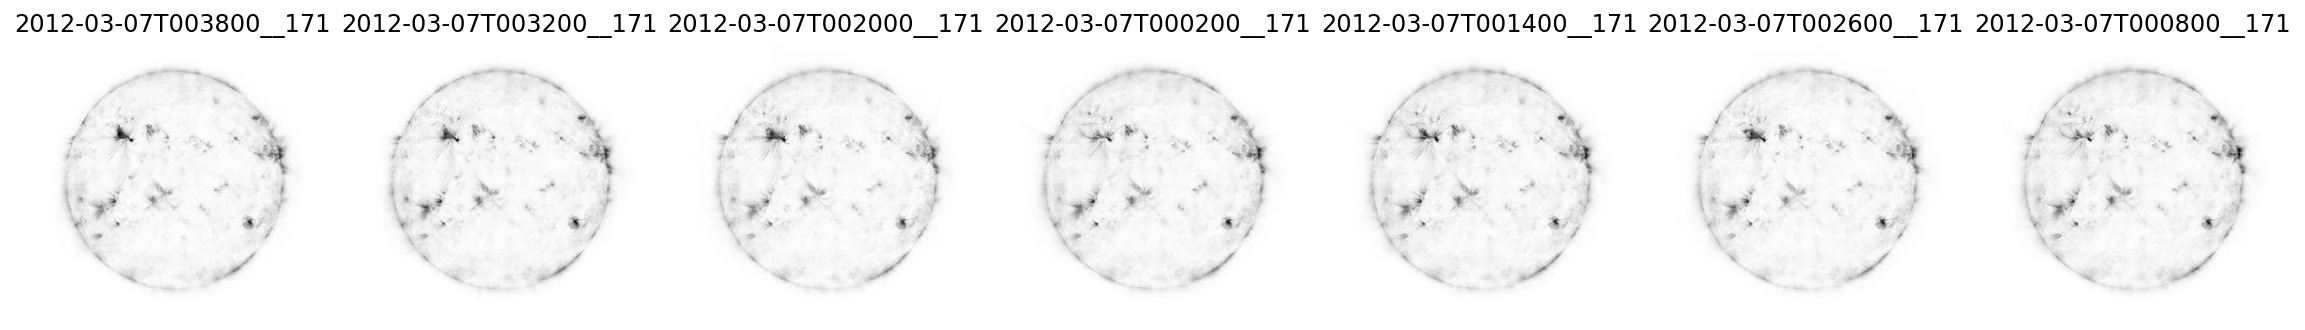

In [31]:
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' 

pixel_pred_path = "./output/pred/20210216-170655_cevae/predictions"
aia_wave = 171
images = list(Path(pixel_pred_path).rglob(f'*__{aia_wave}.jpeg'))

f, axarr = plt.subplots(1,7, figsize=(20, 9))

row_index = 0
column_index = 0

for index, path in enumerate(images):
    img = Image.open(path)
    img_arr = np.invert(np.asarray(img))
    axarr[column_index].set_title(path.stem)
    axarr[column_index].imshow(img_arr, cmap='gray', vmin=0, vmax=255)
    axarr[column_index].spines['top'].set_visible(False)
    axarr[column_index].spines['right'].set_visible(False)
    axarr[column_index].spines['bottom'].set_visible(False)
    axarr[column_index].spines['left'].set_visible(False)
    axarr[column_index].xaxis.set_ticks([])
    axarr[column_index].yaxis.set_ticks([])

    if(column_index == 6):
        row_index = (row_index + 1)
        
    column_index = (column_index + 1) % 7

In [10]:
# sample-level predictions

!python3 ../src/sood/algorithms/ce_vae.py \
    --run="predict" \
    --target-size=256 \
    --data-dir='./data/aia_171_2012_256' \
    --test-dir='./data/aia_171_2012_full_disk_flare_256' \
    --load-path='./output/train/20210216-164014_cevae/checkpoint' \
    -o './output/pred' \
    --logger visdom \
    --ce-factor 0.5 \
    --score-mode combi \
    --mode="sample"

Setting up a new session...
VAE(
  (enc): BasicEncoder(
    (start): ConvModule(
      (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (activation): LeakyReLU(negative_slope=0.01)
    )
    (middle_blocks): ModuleList(
      (0): NoOp()
      (1): ConvModule(
        (conv): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (activation): LeakyReLU(negative_slope=0.01)
      )
      (2): NoOp()
      (3): ConvModule(
        (conv): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (activation): LeakyReLU(negative_slope=0.01)
      )
      (4): NoOp()
      (5): ConvModule(
        (conv): Conv2d(256, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (activation): LeakyReLU(negative_slope=0.01)
      )
    )
    (end): ConvModule(
      (conv): Conv2d(1024, 256, kernel_size=[16, 16], stride=(1, 1), bias=False)
    )
  )
  (dec): BasicGenerator(
 

In [39]:
import pandas as pd

sample_pred_path = "./output/pred/20210216-170850_cevae/predictions/predictions.txt"
df = pd.read_csv(sample_pred_path, header=None, names = ["img", "score"])
df.head(7)

,img,score
0,2012-03-07T000200__171.jpeg,0.188854
1,2012-03-07T000800__171.jpeg,0.188816
2,2012-03-07T001400__171.jpeg,0.189837
3,2012-03-07T002000__171.jpeg,0.195245
4,2012-03-07T002600__171.jpeg,0.192732
5,2012-03-07T003200__171.jpeg,0.183411
6,2012-03-07T003800__171.jpeg,0.183029


In [40]:
df.describe()

,score
count,7.000000
mean,0.188846
std,0.004480
min,0.183029
25%,0.186113
50%,0.188854
75%,0.191285
max,0.195245
